## Summary
This notebook builds on the exploratory data analysis conducted previously, and experiments with multiple machine learning models in an attempt to maximize accuracy. The models we apply will be from the Scikit-Learn library.

The original dataset and an explanation of each of the features is available on Kaggle [here](https://www.kaggle.com/ronitf/heart-disease-uci).

In [397]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

heart_data = pd.read_csv('heart.csv')

We'll repeat the data cleaning steps we took in our EDA notebook:


In [398]:
heart_data = heart_data.drop([85, 92, 158, 163, 164, 251], axis=0)

In [399]:
heart_data.shape

(297, 14)

## Logistic Regression
Since we're predicting a classification label, an obvious model choice to start with is Logistic Regression. First, let's assign our X and y. We'll also assign a random state variable to maintain consistency as we run our code repeatedly.

In [400]:
X = heart_data.drop(columns=['target'])
y = heart_data['target']
r_state = 42

We'll use the train_test_split function from scikit-learn and set our test size to 30%.

In [401]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=r_state)

Let's check the size of X_train to ensure that it took 70% of our rows, as well as the shape of X_test. Together, the number of rows should sum to 297, the shape of our original data set after cleaning.

In [402]:
X_train.shape

(207, 13)

In [403]:
X_test.shape

(90, 13)

## Model 1
Next, we'll create and fit our Logistic Regression model:

In [404]:
my_model = LogisticRegression(random_state=r_state)
my_model.fit(X_train, y_train)

/Users/robineastwood/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Now that our model has been trained on the data, we'll predict the labels of our test set. The variable we create, y_pred, will hold an array of 90 categorical labels (0 or 1).

In [405]:
y_pred = my_model.predict(X_test)
y_pred

array([1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1])

Let's evaluate our model using accuracy, which is the most straightforward measure of success and a good place to start. We'll use scikit-learn's .score() function and compare our test labels and our model's prediction labels.

In [406]:
my_model_score = my_model.score(X_test, y_test)
my_model_score

0.8444444444444444

Not bad. Without any additional feature engineering, we can predict with about 84% accuracy whether or not a subject will have heart disease given a set of features.

## Model 2
Let's try running our model again but only using the feature columns that have at least a +/-0.3 correlation with our target. Based on the .corr() we did in our EDA notebook, that would be:
- cp
- thalach
- exang
- oldpeak
- slope
- ca
- thal

In [407]:
subset_features = ['cp', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
X = heart_data[subset_features]
# our y variable will not change.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=r_state)
my_model_2 = LogisticRegression(random_state=r_state)
my_model_2.fit(X_train, y_train)
y_pred = my_model_2.predict(X_test)
my_model_2_score = my_model_2.score(X_test, y_test)
my_model_2_score

/Users/robineastwood/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8666666666666667

So dropping some of the less correlated features improved our accuracy score a little bit, but not dramatically; we achieved 87% accuracy. 

## Model 3
What if we narrow down our features even further, and only use the columns that have at least a +/-0.4 correlation with our target.

In [408]:
subset_features = ['cp', 'exang', 'oldpeak', 'ca']
X = heart_data[subset_features]
# our y variable will not change.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=r_state)
my_model_3 = LogisticRegression(random_state=r_state)
my_model_3.fit(X_train, y_train)
y_pred = my_model_3.predict(X_test)
my_model_3_score = my_model_3.score(X_test, y_test)
my_model_3_score

/Users/robineastwood/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7777777777777778

That made our accuracy score decrease to 78%! We are eliminating too much feature data now. Let's try some other methods.

## Model 4
I'd like to see what happens when we apply one-hot encoding to our categorical features. Since they're not scaled/ranked measurements, I think it's possible that the model is misinterpretting their meaning. We'll use the pandas function .get_dummies() applied to our categorical features.

In [409]:
dummied_data = pd.get_dummies(heart_data, columns = 
                              ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'])
dummied_data.head()

,age,trestbps,chol,thalach,oldpeak,target,sex_0,sex_1,cp_0,cp_1,...,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,thal_0,thal_1,thal_2,thal_3
0,63,145,233,150,2.3,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
1,37,130,250,187,3.5,1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
2,41,130,204,172,1.4,1,1,0,0,1,...,0,1,1,0,0,0,0,0,1,0
3,56,120,236,178,0.8,1,0,1,0,1,...,0,1,1,0,0,0,0,0,1,0
4,57,120,354,163,0.6,1,1,0,1,0,...,0,1,1,0,0,0,0,0,1,0


This creates many more columns than we had before, since each previous column is expanded to the number of categories it includes. We now have 31 columns of data. Let's run our Logistic Regression model again using our dummied data.

In [410]:
X = dummied_data.drop(columns=['target'])
# our y variable will not change.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=r_state)
my_model_4 = LogisticRegression(random_state=r_state)
my_model_4.fit(X_train, y_train)
y_pred = my_model_4.predict(X_test)
my_model_4_score = my_model_4.score(X_test, y_test)
my_model_4_score

/Users/robineastwood/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8444444444444444

Wow! Model 4 gives us the exact same accuracy measure as Model 1: 84%.

## Model 5
What if we continue with one-hot encoding, but only utilize the features that have +/-0.3 correlation coefficients, as we did in Model 2.

In [411]:
dummied_data = pd.get_dummies(heart_data, columns = 
                              ['cp', 'exang', 'slope', 'ca', 'thal'])
dummied_data = dummied_data.drop(columns=['age', 'sex', 'trestbps', 'chol', 'fbs', 'restecg', 'target'])
X = dummied_data
# our y variable will not change.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=r_state)
my_model_5 = LogisticRegression(random_state=r_state)
my_model_5.fit(X_train, y_train)
y_pred = my_model_5.predict(X_test)
my_model_5_score = my_model_5.score(X_test, y_test)
my_model_5_score

/Users/robineastwood/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8666666666666667

And Model 5 gives us the exact same accuracy measure as Model 2, at 87%! I think it's safe to say that one-hot encoding has no influence on this data set when using a Logistic Regression model.

## Nearest Neighbors
Let's try a machine learning model other than Logistic Regression next. Scikit Learn has a Nearest Neighbors Classification model. As a baseline, we'll use our full data set, without applying one-hot encoding.

## Model 6

In [412]:
X = heart_data.drop(columns=['target'])
# our y variable will not change.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=r_state)
my_model_6 = KNeighborsClassifier(n_neighbors=15)
my_model_6.fit(X_train, y_train)
y_pred = my_model_6.predict(X_test)
my_model_6_score = my_model_6.score(X_test, y_test)
my_model_6_score

0.6888888888888889

I did a quick experiment with the number of n_neighbors to use, and 15 seems to give us the best result at 69% accuracy, which still isn't very good.

## Model 7
Let's try the KNN model after applying one-hot encoding.

In [413]:
dummied_data = pd.get_dummies(heart_data, columns = 
                              ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'])
X = dummied_data.drop(columns=['target'])
# our y variable will not change.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=r_state)
my_model_7 = KNeighborsClassifier(n_neighbors=15)
my_model_7.fit(X_train, y_train)
y_pred = my_model_7.predict(X_test)
my_model_7_score = my_model_7.score(X_test, y_test)
my_model_7_score

0.6888888888888889

Evidently one-hot encoding doesn't have any effect when utilizing the KNN model either; we've again achieved an accuracy score of 69%.

## Decision Tree
Scikit Learn also has a Decision Tree Classification model. As a baseline, we'll again use our full data set, without applying one-hot encoding.

## Model 8


In [414]:
X = heart_data.drop(columns=['target'])
# our y variable will not change.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=r_state)
my_model_8 = DecisionTreeClassifier(random_state=r_state)
my_model_8.fit(X_train, y_train)
y_pred = my_model_8.predict(X_test)
my_model_8_score = my_model_8.score(X_test, y_test)
my_model_8_score

0.7444444444444445

The decision tree model gives us an accuracy score of about 74%, which is still far below our earlier logistic regression model.

## Support Vector Machine

## Model 9
Our ninth model will explore the Support Vector Machine model in the Scikit-Learn library.

In [415]:
X = heart_data.drop(columns=['target'])
# our y variable will not change.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=r_state)
my_model_9 = svm.SVC(kernel='linear')
my_model_9.fit(X_train, y_train)
y_pred = my_model_9.predict(X_test)
my_model_9_score = my_model_9.score(X_test, y_test)
my_model_9_score

0.8222222222222222

Well, at least our accuracy score has crept back into the 80-something percentile, more in range with our initial logistic regression model.

## Gaussian Naive Bayes
## Model 10
Our tenth model will use the Gaussian Naive Bayes model.

In [416]:
X = heart_data.drop(columns=['target'])
# our y variable will not change.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=r_state)
my_model_10 = GaussianNB()
my_model_10.fit(X_train, y_train)
y_pred = my_model_10.predict(X_test)
my_model_10_score = my_model_10.score(X_test, y_test)
my_model_10_score

0.8

The Gaussian Naive Bayes model has yielded us 80% accuracy.

## Random Forest Classifier
## Model 11
Lastly, we'll build and train a Random Forest Classifier.

In [419]:
X = heart_data.drop(columns=['target'])
# our y variable will not change.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=r_state)
my_model_11 = RandomForestClassifier()
my_model_11.fit(X_train, y_train)
y_pred = my_model_11.predict(X_test)
my_model_11_score = my_model_11.score(X_test, y_test)
my_model_11_score

/Users/robineastwood/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8222222222222222

An accuracy score of 82% rounds out our experimental models.

## Review and Summary
Let's take a moment to visualize the accuracy scores of the many models we've built. First we'll create a pandas dataframe of the accuracy scores so that we can pass that data into our plotting tools.

In [330]:
accuracy_score_df = pd.DataFrame(
    {
    'Model 1': [my_model_score], 
    'Model 2': [my_model_2_score], 
    'Model 3': [my_model_3_score],
    'Model 4': [my_model_4_score],
    'Model 5': [my_model_5_score],
    'Model 6': [my_model_6_score],
    'Model 7': [my_model_7_score],
    'Model 8': [my_model_8_score],
    'Model 9': [my_model_9_score],
    'Model 10': [my_model_10_score],
    'Model 11': [my_model_11_score]
    })

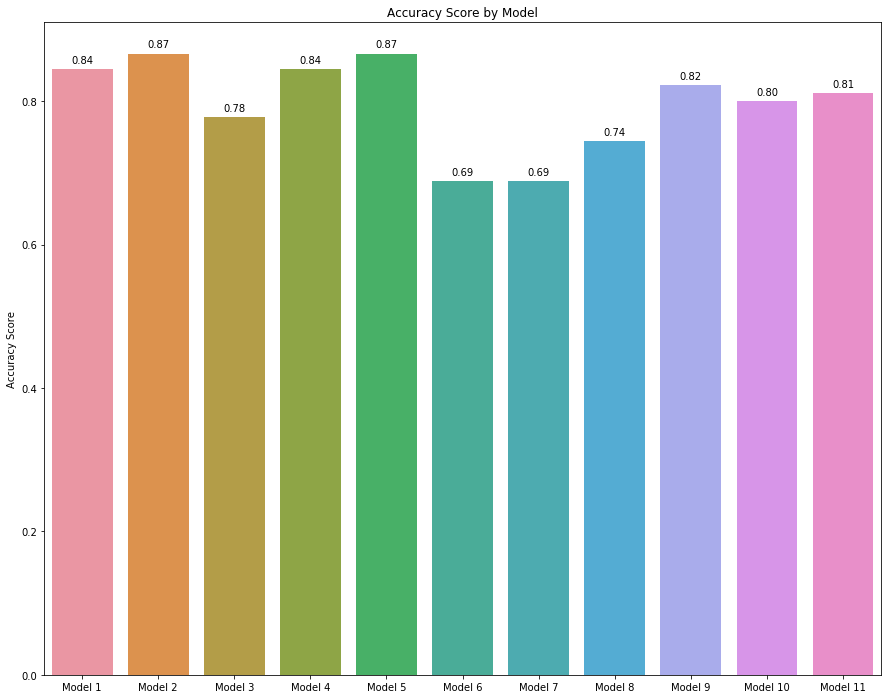

In [423]:
fig_dims = (15, 12)
fig = plt.subplots(figsize=fig_dims)
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score by Model')
splot = sns.barplot(data=accuracy_score_df)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center', 
                   xytext = (0, 9),
                   textcoords = 'offset points')
plt.show()

As we can see, Models 2 and 5 had the highest accuracy scores (as you'll recall, the scores of these two models were the same, as we used the exact same parameters excepting Model 5 was one-hot encoded). So Logistic Regression was the highest performer for this dataset; 87% accuracy is a decent measure. Let's take model 2 and explore it a little further.

Since we've built so many models in this notebook and reused variable names, let's rebuild Model 2 first.

In [332]:
subset_features = ['cp', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
X = heart_data[subset_features]
# our y variable will not change.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=r_state)
my_model_2 = LogisticRegression(random_state=r_state)
my_model_2.fit(X_train, y_train)
y_pred = my_model_2.predict(X_test)
my_model_2_score = my_model_2.score(X_test, y_test)

/Users/robineastwood/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


A classification report will allow us to see our most important metrics:

In [333]:
print(classification_report(y_test, y_pred, target_names=('0=heart disease', '1=no heart disease')))

                    precision    recall  f1-score   support

   0=heart disease       0.88      0.79      0.83        38
1=no heart disease       0.86      0.92      0.89        52

          accuracy                           0.87        90
         macro avg       0.87      0.86      0.86        90
      weighted avg       0.87      0.87      0.87        90



Let's break these numbers down.
**Precision** tells us what percentage of our predictions were correct, looking at true positives as a percentage of all positives. For target 0 we predicted correctly 88% of the time, for target 1 we predicted correctly 86% of the time.
**Recall** tells us the percentage of positive cases we caught. For target 0 we caught 79% of cases, for target 1 we caught 92% of cases. That means we missed 21% of cases where subjects did have heart disease, assigning them a false negative label.
The **F1 score** is a formulaic measure of precision and recall together.

**Accuracy** is the most straightforward metric and the one we've been primarily evaluating thus far. It is a measure of our correct predictions as a percentage of all predictions made.

And a confusion matrix will give us a tabular visual on the true/false positives/negatives.

In [335]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[30  8]
 [ 4 48]]


- 30 True Positives
- 4 False Negatives
- 8 False Positives
- 48 True Negatives

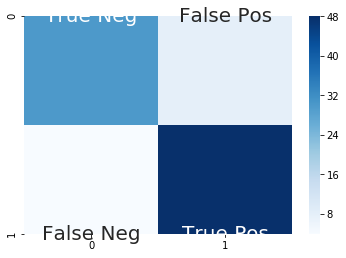

In [382]:
confusion_df = pd.DataFrame(confusion_matrix)
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_df, 
            annot=labels, 
            fmt='',
            annot_kws={"size": 20},
            cmap='Blues'
           )
plt.show()